In [1]:
import numpy as np 
import pandas as pd 

In [2]:
df = pd.read_csv("full.csv")

/tmp/ipykernel_11986/2471715599.py:1: DtypeWarning: Columns (10,12,14,17,18,20,22,24,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("full.csv")


On sélectionne les départements de la Nouvelle-Aquitaine

In [3]:
#df = df[df['code_departement'].isin([1, 3, 7, 15, 26, 38, 42, 43, 63, 69, 73, 74])]
df = df[df['code_departement'].isin([16, 17, 19, 23, 24, 33, 40, 47, 64, 79, 86, 87])]


On ne garde que les ventes, les lignes à 0 ou 1 lot.

On ne garde que les lignes dont la surface terrain et la valeur foncière sont bien définies et non nulles.

In [4]:
df = df[df['nature_mutation'].isin(["Vente", "Vente en l'état futur d'achèvement"])]
df = df[df['nombre_lots'].isin([0, 1])]
df = df.dropna(subset=['surface_terrain', 'surface_reelle_bati', 'valeur_fonciere', 'latitude', 'longitude'])
df = df[~(df['surface_terrain'] == 0)]
df = df[~(df['valeur_fonciere'] == 0)]


On ne retient que les colonnes qui nous intéressent, et on réinitialise l'indexage.

In [5]:
df = df[['valeur_fonciere', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'surface_terrain', 'longitude', 'latitude']]

df = df.reset_index(drop=True)

Dans les cases suivantes, on va chercher à calculer pour chaque entrée le prix moyen du voisinage.

On définit le voisinage comme les dix ventes les plus proches d'une entrée.

On fait appel à une structure BallTree pour déterminer, pour chaque entrée, les dix ventes les plus proches. 

In [6]:
df["prix_m2"] = df.apply(lambda row: row['valeur_fonciere'] / row['surface_reelle_bati'], axis=1)
df['prix_m2_voisinage'] = np.zeros(len(df))

In [7]:
from sklearn.neighbors import BallTree

tree = BallTree(df[['latitude', 'longitude']].values, metric='haversine')

In [8]:
indices_array = tree.query(df[['latitude', 'longitude']].values, k=11, return_distance=False)

In [9]:
for i, indices in enumerate(indices_array):
    df.iloc[i, df.columns.get_loc('prix_m2_voisinage')] = df.iloc[indices[1:], df.columns.get_loc('prix_m2')].sum() / 10

In [10]:
df.head()

,valeur_fonciere,code_postal,code_commune,nom_commune,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_m2,prix_m2_voisinage
0,221000.0,16400.0,16418,Vœuil-et-Giget,16,Maison,80.0,4.0,880.0,0.156614,45.584987,2762.500000,3998.043925
1,221000.0,16400.0,16418,Vœuil-et-Giget,16,Maison,80.0,4.0,500.0,0.156614,45.584987,2762.500000,3998.043925
2,116500.0,16000.0,16015,Angoulême,16,Maison,88.0,5.0,58.0,0.176444,45.648704,1323.863636,3375.791865
3,126000.0,16340.0,16166,L'Isle-d'Espagnac,16,Maison,91.0,4.0,956.0,0.191596,45.661171,1384.615385,1525.448718
4,250000.0,16100.0,16102,Cognac,16,Maison,151.0,6.0,826.0,-0.309153,45.696703,1655.629139,1558.535327


## Standardisation, dummy expansion

On effectue une dummy expansion de la variable `type_local`.

In [11]:
df = pd.concat([df, pd.get_dummies(df[["type_local"]])], axis=1)

On standardise les variables `prix_m2`, `prix_m2_voisinage` et `valeur_fonciere`.

In [12]:
from sklearn.preprocessing import StandardScaler

prix_m2_scaler = StandardScaler()
prix_m2_scaled = prix_m2_scaler.fit_transform(df[["prix_m2"]])

prix_m2_voisinage_scaler = StandardScaler()
prix_m2_voisinage_scaled = prix_m2_voisinage_scaler.fit_transform(df[["prix_m2_voisinage"]])

valeur_fonciere_scaler = StandardScaler()
valeur_fonciere_scaled = valeur_fonciere_scaler.fit_transform(df[["valeur_fonciere"]])

In [13]:
df[["prix_m2_scaled"]] = prix_m2_scaled
df[["prix_m2_voisinage_scaled"]] = prix_m2_voisinage_scaled
df[["valeur_fonciere_scaled"]] = valeur_fonciere_scaled

In [14]:
df

,valeur_fonciere,code_postal,code_commune,nom_commune,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_m2,prix_m2_voisinage,type_local_Appartement,type_local_Local industriel. commercial ou assimilé,type_local_Maison,prix_m2_scaled,prix_m2_voisinage_scaled,valeur_fonciere_scaled
0,221000.0,16400.0,16418,Vœuil-et-Giget,16,Maison,80.0,4.0,880.0,0.156614,45.584987,2762.500000,3998.043925,0,0,1,-0.093247,-0.041854,-0.113376
1,221000.0,16400.0,16418,Vœuil-et-Giget,16,Maison,80.0,4.0,500.0,0.156614,45.584987,2762.500000,3998.043925,0,0,1,-0.093247,-0.041854,-0.113376
2,116500.0,16000.0,16015,Angoulême,16,Maison,88.0,5.0,58.0,0.176444,45.648704,1323.863636,3375.791865,0,0,1,-0.179090,-0.086773,-0.210911
3,126000.0,16340.0,16166,L'Isle-d'Espagnac,16,Maison,91.0,4.0,956.0,0.191596,45.661171,1384.615385,1525.448718,0,0,1,-0.175465,-0.220345,-0.202044
4,250000.0,16100.0,16102,Cognac,16,Maison,151.0,6.0,826.0,-0.309153,45.696703,1655.629139,1558.535327,0,0,1,-0.159293,-0.217957,-0.086309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131472,260000.0,87500.0,87187,Saint-Yrieix-la-Perche,87,Maison,149.0,4.0,13806.0,1.184439,45.488690,1744.966443,1217.895174,0,0,1,-0.153963,-0.242547,-0.076975
131473,175000.0,87350.0,87114,Panazol,87,Maison,91.0,4.0,225.0,1.290530,45.822054,1923.076923,2771.489232,0,0,1,-0.143335,-0.130396,-0.156310
131474,149000.0,87200.0,87154,Saint-Junien,87,Maison,85.0,4.0,712.0,0.914763,45.890803,1752.941176,1986.571545,0,0,1,-0.153487,-0.187058,-0.180577
131475,43000.0,87150.0,87111,Oradour-sur-Vayres,87,Maison,106.0,4.0,44.0,0.897545,45.763998,405.660377,1474.011634,0,0,1,-0.233879,-0.224058,-0.279512


In [15]:
df.columns

Index(['valeur_fonciere', 'code_postal', 'code_commune', 'nom_commune',
       'code_departement', 'type_local', 'surface_reelle_bati',
       'nombre_pieces_principales', 'surface_terrain', 'longitude', 'latitude',
       'prix_m2', 'prix_m2_voisinage', 'type_local_Appartement',
       'type_local_Local industriel. commercial ou assimilé',
       'type_local_Maison', 'prix_m2_scaled', 'prix_m2_voisinage_scaled',
       'valeur_fonciere_scaled'],
      dtype='object')

## Modelisation

On essaye de prédire le prix d'une habitation à l'aide d'un régresseur de type Random Forest.

On définie nos X et y, et on sépare nos données en *train* et *test*.

In [16]:
X = df[['surface_reelle_bati', 'surface_terrain', 'longitude', 'latitude',
       'type_local_Appartement', 'type_local_Local industriel. commercial ou assimilé', 'type_local_Maison', 
       'prix_m2_scaled', 'prix_m2_voisinage_scaled']].values
y = df[['valeur_fonciere_scaled']].values

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [18]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=30, min_samples_split=5)
regr.fit(X_train, y_train)

/tmp/ipykernel_11986/3301792599.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


RandomForestRegressor(min_samples_split=5, n_estimators=30)

On calcule le R2 de notre modèle.

In [19]:
regr.score(X_test, y_test)

0.9131052345858508

 ## Une carte


On va construire la carte du prix moyen au m² par département.

In [20]:
import geopandas as gpd 
import cartiflette.s3

In [21]:
shp_departements = gpd.read_file("DEPARTEMENT.shp")

In [22]:
shp_departements.head()

,ID,NOM_M,NOM,INSEE_DEP,INSEE_REG,geometry
0,DEPARTEM_FXX_00000000001,AIN,Ain,01,84,"POLYGON ((838383.200 6570485.800, 838483.800 6..."
1,DEPARTEM_FXX_00000000002,AISNE,Aisne,02,32,"POLYGON ((708719.000 6956305.000, 708718.700 6..."
2,DEPARTEM_FXX_00000000003,CORSE-DU-SUD,Corse-du-Sud,2A,94,"MULTIPOLYGON (((1164319.900 6102528.800, 11643..."
3,DEPARTEM_FXX_00000000004,HAUTE-CORSE,Haute-Corse,2B,94,"MULTIPOLYGON (((1221854.400 6235267.200, 12218..."
4,DEPARTEM_FXX_00000000005,ALLIER,Allier,03,84,"POLYGON ((664478.800 6602292.500, 664503.600 6..."


In [23]:
shp_departements.crs

<Derived Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [33]:
shp_departements = shp_departements[shp_departements["INSEE_DEP"].isin(["16", "17", "19", "23", "24", "33", "40", "47", "64", "79", "86", "87"])]
shp_departements.reset_index(drop=True, inplace=True)

In [35]:
shp_departements.head()

,ID,NOM_M,NOM,INSEE_DEP,INSEE_REG,geometry,prix_m2_moyen
0,DEPARTEM_FXX_00000000018,CHARENTE,Charente,16,75,"POLYGON ((458320.400 6534459.100, 458323.500 6...",NaN
1,DEPARTEM_FXX_00000000019,CHARENTE-MARITIME,Charente-Maritime,17,75,"MULTIPOLYGON (((379483.800 6553291.300, 379484...",NaN
2,DEPARTEM_FXX_00000000021,CORREZE,Corrèze,19,75,"POLYGON ((603730.000 6506867.600, 603750.200 6...",NaN
3,DEPARTEM_FXX_00000000024,CREUSE,Creuse,23,75,"POLYGON ((614277.500 6593135.200, 614318.000 6...",NaN
4,DEPARTEM_FXX_00000000025,DORDOGNE,Dordogne,24,75,"POLYGON ((466960.300 6440219.900, 466986.000 6...",NaN


In [36]:
from shapely.geometry import Point

df["geometry"] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)

/home/jacquesyves/miniconda3/envs/ds/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [37]:
df = gpd.GeoDataFrame(df)
df.crs = 4326
df = df.to_crs(2154)

In [38]:
df.crs

<Derived Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [39]:
for k in range(len(shp_departements)):
    dep = int(shp_departements.loc[k, "INSEE_DEP"])
    temp_df = df[df["code_departement"] == dep]
    shp_departements.loc[k, "prix_m2_moyen"] = temp_df["prix_m2"].mean()

In [40]:
shp_departements

,ID,NOM_M,NOM,INSEE_DEP,INSEE_REG,geometry,prix_m2_moyen
0,DEPARTEM_FXX_00000000018,CHARENTE,Charente,16,75,"POLYGON ((458320.400 6534459.100, 458323.500 6...",2796.423563
1,DEPARTEM_FXX_00000000019,CHARENTE-MARITIME,Charente-Maritime,17,75,"MULTIPOLYGON (((379483.800 6553291.300, 379484...",4217.256791
2,DEPARTEM_FXX_00000000021,CORREZE,Corrèze,19,75,"POLYGON ((603730.000 6506867.600, 603750.200 6...",2114.557350
3,DEPARTEM_FXX_00000000024,CREUSE,Creuse,23,75,"POLYGON ((614277.500 6593135.200, 614318.000 6...",1273.771846
4,DEPARTEM_FXX_00000000025,DORDOGNE,Dordogne,24,75,"POLYGON ((466960.300 6440219.900, 466986.000 6...",2603.082656
5,DEPARTEM_FXX_00000000034,GIRONDE,Gironde,33,75,"MULTIPOLYGON (((376139.300 6509082.400, 376152...",9084.481495
6,DEPARTEM_FXX_00000000041,LANDES,Landes,40,75,"POLYGON ((351156.100 6332120.700, 351157.700 6...",3658.193840
7,DEPARTEM_FXX_00000000048,LOT-ET-GARONNE,Lot-et-Garonne,47,75,"POLYGON ((530970.900 6390988.400, 530992.700 6...",2262.675493
8,DEPARTEM_FXX_00000000065,PYRENEES-ATLANTIQUES,Pyrénées-Atlantiques,64,75,"MULTIPOLYGON (((329563.000 6273422.400, 329566...",6578.364261
9,DEPARTEM_FXX_00000000080,DEUX-SEVRES,Deux-Sèvres,79,75,"POLYGON ((456863.500 6670815.800, 456879.700 6...",1834.823560


Text(0.5, 1.0, 'Prix moyen au m² des habitations de la région Nouvelle-Aquitaine')

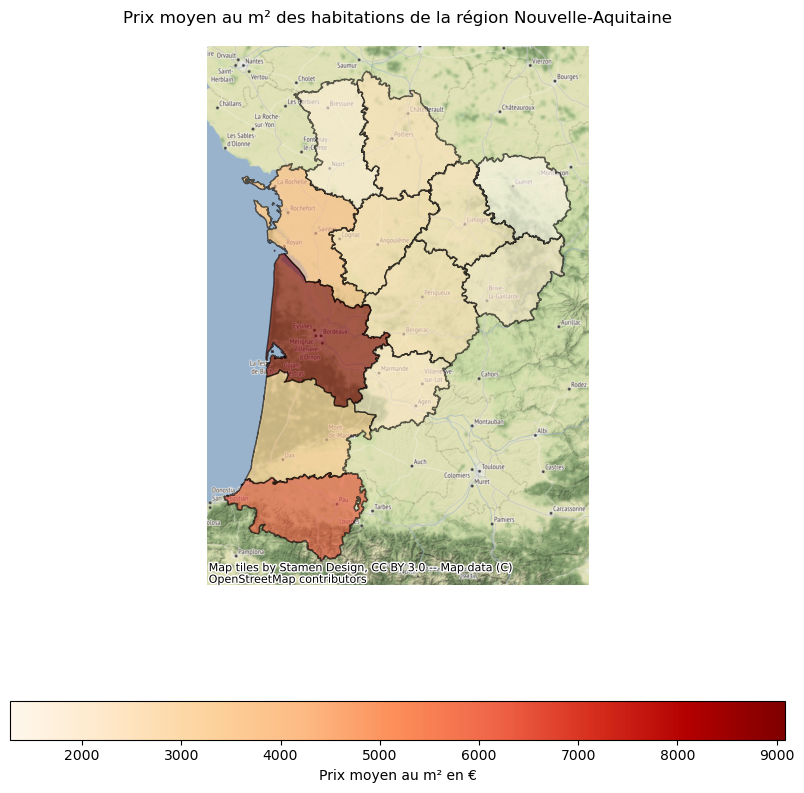

In [41]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(10, 10))
shp_departements.to_crs(3857).plot(
    column="prix_m2_moyen", 
    ax=ax, 
    edgecolor="black",
    cmap='OrRd',
    alpha=0.6,
    legend=True, 
    legend_kwds={'label': "Prix moyen au m² en €", 'orientation': "horizontal"})

import contextily as ctx

ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain)

ax.set_axis_off()
ax.set_title("Prix moyen au m² des habitations de la région Nouvelle-Aquitaine")